# Experiments

In [1]:
from tqdm import tqdm

from dlgan_training import num_embeddings
!nvidia-smi

Sat Aug 17 15:10:38 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.41                 Driver Version: 552.41         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   43C    P8              7W /  320W |    1153MiB /  16376MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# required imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from ksvd import ApproximateKSVD # baseline
from skimage import data, io, util
from sklearn.feature_extraction import image
from tqdm import tqdm

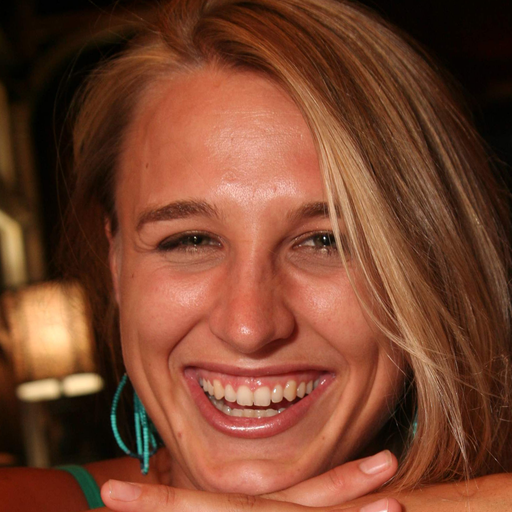

In [3]:
# read the image
test = Image.open('test.png')
display(test)

In [4]:
# convert the image to torch tensor
image_tensor = torch.tensor(np.array(test))
image_tensor = image_tensor.permute(2, 0, 1)
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.float()
image_tensor /= 255.0

In [5]:
print(image_tensor.shape)

torch.Size([1, 3, 512, 512])


In [6]:
# a simple test with synthetic data
# X ~ gamma.dot(dictionary)

X = np.random.randn(1000, 20)
aksvd = ApproximateKSVD(n_components=128, max_iter=100)
dictionary = aksvd.fit(X).components_
gamma = aksvd.transform(X)

In [7]:
X_hat = gamma.dot(dictionary)

In [8]:
# compute mse
mse = np.mean((X - X_hat) ** 2)
print(mse)

0.2742357717950327


## Test with a general purpose image

In [9]:
img = data.coffee()
io.imsave('coffee.png', img)

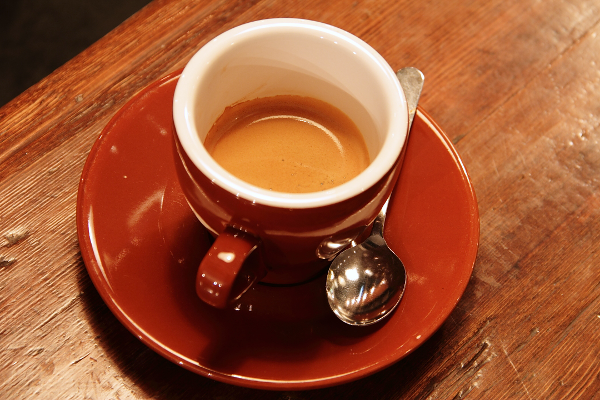

In [10]:
# read the image
original = Image.open('coffee.png')
display(original)

In [11]:
# add noise to the image
img = util.img_as_float(original)

In [12]:
def clip(img):
    img = np.minimum(np.ones(img.shape), img)
    img = np.maximum(np.zeros(img.shape), img)
    
    return img

In [13]:
%%time

patch_size = (10, 10)
patches = image.extract_patches_2d(img, patch_size)
signals = patches.reshape(patches.shape[0], -1)
# mean = np.mean(signals, axis=1)[:, np.newaxis]
# signals -= mean

CPU times: total: 31.2 ms
Wall time: 178 ms


In [14]:
print(signals.shape)

(231081, 300)


In [15]:
%%time

aksvd = ApproximateKSVD(n_components=32)
dictionary = aksvd.fit(signals[:1000]).components_
gamma = aksvd.transform(signals)
# reduced = gamma.dot(dictionary) + mean
reduced = gamma.dot(dictionary)

CPU times: total: 16.8 s
Wall time: 1min 33s


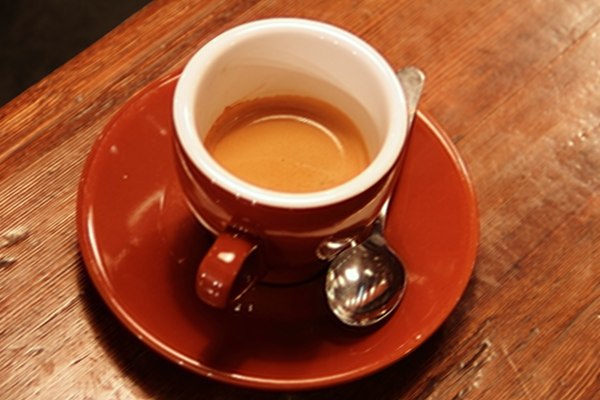

In [16]:
reduced_img = image.reconstruct_from_patches_2d(reduced.reshape(patches.shape), img.shape)
reduced_img = clip(reduced_img)
reduced_img = (255 * reduced_img).astype(np.uint8)
display(Image.fromarray(reduced_img))

## PyTorch Implementation

In [61]:
def _update_logical(logical, to_add):
    running_idx = torch.arange(to_add.shape[0], device=to_add.device)
    logical[running_idx, to_add] = 1

def reconstruction_distance(D, cur_Z, last_Z):
    distance = torch.norm(D.mm(last_Z - cur_Z), p=2, dim=0) / torch.norm(D.mm(last_Z), p=2, dim=0)
    max_distance = distance.max()
    return distance, max_distance

def OMP(X, D, K, tolerance, debug=False):
    Dt = D.t()
    Dpinv = torch.pinverse(D)
    r = X
    I = []
    stopping = False
    last_sparse_code = torch.zeros((D.size()[1], X.size()[1]), dtype=X.dtype).cuda()
    sparse_code = torch.zeros((D.size()[1], X.size()[1]), dtype=X.dtype).cuda()

    step = 0
    while not stopping:
        k_hat = torch.argmax(Dt.mm(r), 0)
        I.append(k_hat)
        sparse_code = Dpinv.mm(X) # Should be: (torch.pinverse(D[:,I])*X).sum(0)
        r = X - D.mm(sparse_code)

        distance, max_distance = reconstruction_distance(D, sparse_code, last_sparse_code)
        stopping = len(I) >= K or max_distance < tolerance
        last_sparse_code = sparse_code

        if debug and step % 1 == 0:
            print('Step {}, code improvement: {}, below tolerance: {}'.format(step, max_distance, (distance < tolerance).float().mean().item()))

        step += 1

    return sparse_code

def Batch_OMP(data, dictionary, max_nonzero, tolerance=1e-4, debug=False):
    """
    for details on variable names, see
    https://sparse-plex.readthedocs.io/en/latest/book/pursuit/omp/batch_omp.html
    or the original paper
    http://www.cs.technion.ac.il/~ronrubin/Publications/KSVD-OMP-v2.pdf

    NOTE - the implementation below works on transposed versions of the input signal to make the batch size the first
           coordinate, which is how pytorch expects the data..
    """
    vector_dim, batch_size = data.size()
    dictionary_t = dictionary.t()
    G = dictionary_t.mm(dictionary)  # this is a Gram matrix
    eps = torch.norm(data, dim=0)  # the residual, initalized as the L2 norm of the signal
    h_bar = dictionary_t.mm(data).t()  # initial correlation vector, transposed to make batch_size the first dimension

    # note - below this line we no longer use "data" or "dictionary"

    h = h_bar
    x = torch.zeros_like(h_bar)  # the resulting sparse code
    L = torch.ones(batch_size, 1, 1, device=h.device)  # Contains the progressive Cholesky of G in selected indices
    I = torch.ones(batch_size, 0, device=h.device).long()
    I_logic = torch.zeros_like(h_bar).bool()  # used to zero our elements is h before argmax
    delta = torch.zeros(batch_size, device=h.device)  # to track errors

    k = 0
    while k < max_nonzero:
        k += 1
        # use "I_logic" to make sure we do not select same index twice
        index = (h*(~I_logic)).abs().argmax(dim=1)  # todo - can we use "I" rather than "I_logic"
        # print(f'DEBUG: index={index}')
        _update_logical(I_logic, index)
        batch_idx = torch.arange(batch_size, device=G.device)
        expanded_batch_idx = batch_idx.unsqueeze(0).expand(k, batch_size).t()

        if k > 1:  # Cholesky update
            # Following line is equivalent to:
            #   G_stack = torch.stack([G[I[i, :], index[i]] for i in range(batch_size)], dim=0).view(batch_size, k-1, 1)
            G_stack = G[I[batch_idx, :], index[expanded_batch_idx[...,:-1]]].view(batch_size, k - 1, 1)
            w = torch.linalg.solve_triangular(L, G_stack, upper=False).view(-1, 1, k - 1)
            w_corner = torch.sqrt(1-(w**2).sum(dim=2, keepdim=True))  # <- L corner element: sqrt(1- w.t().mm(w))

            # do concatenation into the new Cholesky: L <- [[L, 0], [w, w_corner]]
            k_zeros = torch.zeros(batch_size, k-1, 1, device=h.device)
            L = torch.cat((
                torch.cat((L, k_zeros), dim=2),
                torch.cat((w, w_corner), dim=2),
            ), dim=1)

        # update non-zero indices
        I = torch.cat([I, index.unsqueeze(1)], dim=1)

        # if debug:
        #   print(f'DEBUG: I={I}')

        # x = solve L
        # The following line is equivalent to:
        #   h_stack = torch.stack([h_bar[i, I[i, :]] for i in range(batch_size)]).unsqueeze(2)
        h_stack = h_bar[expanded_batch_idx, I[batch_idx, :]].view(batch_size, k, 1)
        x_stack = torch.cholesky_solve(h_stack, L)

        # de-stack x into the non-zero elements
        # The following line is equivalent to:
        #   for i in range(batch_size):
        #       x[i:i+1, I[i, :]] = x_stack[i, :].t()
        x[batch_idx.unsqueeze(1), I[batch_idx]] = x_stack[batch_idx].squeeze(-1)

        # beta = G_I * x_I
        # The following line is equivalent to:
        # beta = torch.cat([x[i:i+1, I[i, :]].mm(G[I[i, :], :]) for i in range(batch_size)], dim=0)
        beta = x[batch_idx.unsqueeze(1), I[batch_idx]].unsqueeze(1).bmm(G[I[batch_idx], :]).squeeze(1)

        h = h_bar - beta

        # update residual
        new_delta = (x * beta).sum(dim=1)
        eps += delta-new_delta
        delta = new_delta

        if debug and k % 1 == 0:
            print('Step {}, residual: {:.4f}, below tolerance: {:.4f}'.format(k, eps.max(), (eps < tolerance).float().mean().item()))



    return x.t()  # transpose since sparse codes should be used as D * x


if __name__ == '__main__':
    import time
    from tqdm import tqdm
    torch.manual_seed(0)
    use_gpu = torch.cuda.device_count() > 0
    device = 'cuda' if use_gpu else 'cpu'

    num_nonzeros = 4
    num_samples = int(1e3)
    num_atoms = 512
    embedding_size = 64

    Wd = torch.rand(embedding_size, num_atoms)
    Wd = torch.nn.functional.normalize(Wd, dim=0).to(device)

    codes = []
    for i in tqdm(range(num_samples), desc='generating codes... '):
        tmp = torch.zeros(num_atoms).to(device)
        tmp[torch.randperm(num_atoms)[:num_nonzeros]] = 0.5 * torch.randn(num_nonzeros).to(device) + 0.5
        codes.append(tmp)
    codes = torch.stack(codes, dim=1)
    X = Wd.mm(codes)
    # X += torch.randn(X.size()) / 100  # add noise
    # X = torch.nn.functional.normalize(X, dim=0)  # normalize signal

    if use_gpu:  # warm start?
        print('doing warm start...')
        Batch_OMP(X, Wd, num_nonzeros)
        # batch_omp(Wd.mm(Wd.t()), X, num_nonzeros)
        # OMP(X, Wd, num_nonzeros, 1e-7)

    tic = time.time()
    Z2 = Batch_OMP(X, Wd, num_nonzeros, debug=True)
    Z2_time = time.time() - tic
    print(f'Z2, {torch.isclose(codes, Z2, rtol=1e-03, atol=1e-05).float().mean()}, time/sample={1e6*Z2_time/num_samples/num_nonzeros:.4f}usec')
    pass

generating codes... : 100%|██████████| 1000/1000 [00:00<00:00, 1187.62it/s]

doing warm start...
torch.Size([1000, 1])
torch.Size([1000, 2])
torch.Size([1000, 3])
torch.Size([1000, 4])
torch.Size([1000, 1])
Step 1, residual: 0.8768, below tolerance: 0.8220
torch.Size([1000, 2])
Step 2, residual: 0.4619, below tolerance: 0.8470
torch.Size([1000, 3])
Step 3, residual: 0.3156, below tolerance: 0.8540
torch.Size([1000, 4])
Step 4, residual: 0.2608, below tolerance: 0.8560
Z2, 0.9993184208869934, time/sample=4.0001usec


In [88]:
def batch_omp(signals, dictionary, sparsity_level, tol=1e-7, debug=False):
    """
    Batch Orthogonal Matching Pursuit (OMP) for sparse coding.
    :param gram_matrix: Gram matrix of the dictionary
    :param Dy: Dictionary times data matrix
    :param sparsity_level: maximum number of non-zero coefficients
    :return: sparse coefficients
    
    See:
    - Rubinstein, R., Zibulevsky, M. and Elad, M., "Efficient Implementation of the K-SVD Algorithm using Batch Orthogonal Matching Pursuit," CS Technion, 2008.
    """
    embedding_dim, num_signals = signals.shape
    dictionary_t = dictionary.t() # save the transpose of the dictionary for faster computation
    gram_matrix = dictionary_t.mm(dictionary) # the Gram matrix, dimension: num_atoms x num_atoms
    eps = torch.norm(signals, dim=0) # residual, initialized as the L2 norm of the signal
    corr_init = dictionary_t.mm(signals).t() # initial correlation vector, transposed to make num_signals the first dimension
    gamma = torch.zeros_like(corr_init) # placeholder for the sparse coefficients
    
    corr = corr_init
    L = torch.ones(num_signals, 1, 1, device=signals.device) # contains the progressive Cholesky of the Gram matrix in the selected indices
    I = torch.zeros(num_signals, 0, dtype=torch.long, device=signals.device) # placeholder for the index set
    omega = torch.ones_like(corr_init, dtype=torch.bool) # used to zero out elements in corr before argmax
    signal_idx = torch.arange(num_signals, device=signals.device)
    delta = torch.zeros(num_signals, device=signals.device) # to track residuals
    
    k = 0
    while k < sparsity_level:
        k += 1
        k_hats = torch.argmax(torch.abs(corr * omega), dim=1) # select the index of the maximum correlation
        # update omega to make sure we do not select the same index twice
        omega[torch.arange(k_hats.shape[0], device=signals.device), k_hats] = 0
        expanded_signal_idx = signal_idx.unsqueeze(0).expand(k, num_signals).t() # expand is more efficient than repeat
        
        if k > 1: # Cholesky update
            G_ = gram_matrix[I[signal_idx, :], k_hats[expanded_signal_idx[...,:-1]]].view(num_signals, k - 1, 1) # compute for all signals in a vectorized manner
            w = torch.linalg.solve_triangular(L, G_, upper=False).view(-1, 1, k - 1)
            w_br = torch.sqrt(1 - (w**2).sum(dim=2, keepdim=True)) # L bottom-right corner element: sqrt(1 - w.t().mm(w))
            
            # concatenate into the new Cholesky: L <- [[L, 0], [w, w_br]]
            k_zeros = torch.zeros(num_signals, k - 1, 1, device=signals.device)
            L = torch.cat((
                torch.cat((L, k_zeros), dim=2),
                torch.cat((w, w_br), dim=2),
            ), dim=1)
        
        # update non-zero indices
        I = torch.cat([I, k_hats.unsqueeze(1)], dim=1)
        
        # solve L
        corr_ = corr[expanded_signal_idx, I[signal_idx, :]].view(num_signals, k, 1)
        gamma_ = torch.cholesky_solve(corr_, L)
        
        # de-stack gamma into the non-zero elements
        gamma[signal_idx.unsqueeze(1), I[signal_idx]] = gamma_[signal_idx].squeeze(-1)
        
        # beta = G_I * gamma_I
        beta = gamma[signal_idx.unsqueeze(1), I[signal_idx]].unsqueeze(1).bmm(gram_matrix[I[signal_idx], :]).squeeze(1)
        
        corr = corr_init - beta
        
        # update residual
        new_delta = (gamma * beta).sum(dim=1)
        eps += delta - new_delta
        delta = new_delta
        
        if debug and k % 1 == 0:
            print(f'Step {k}, residual: {eps.max()}, below tolerance: {(eps < tol).float().mean().item()}')

    
    return gamma.t() # transpose the sparse coefficients to make num_signals the first dimension

In [90]:
if __name__ == '__main__':
    import time
    from tqdm import tqdm
    torch.manual_seed(0)
    use_gpu = torch.cuda.device_count() > 0
    device = 'cuda' if use_gpu else 'cpu'

    num_nonzeros = 4
    num_samples = int(1e3)
    num_atoms = 512
    embedding_size = 64

    Wd = torch.rand(embedding_size, num_atoms)
    Wd = torch.nn.functional.normalize(Wd, dim=0).to(device)

    codes = []
    for i in tqdm(range(num_samples), desc='generating codes... '):
        tmp = torch.zeros(num_atoms).to(device)
        tmp[torch.randperm(num_atoms)[:num_nonzeros]] = 0.5 * torch.randn(num_nonzeros).to(device) + 0.5
        codes.append(tmp)
    codes = torch.stack(codes, dim=1)
    X = Wd.mm(codes)
    # X += torch.randn(X.size()) / 100  # add noise
    # X = torch.nn.functional.normalize(X, dim=0)  # normalize signal
    
    if use_gpu:  # warm start?
        print('doing warm start...')
        # Batch_OMP(X, Wd, num_nonzeros)
        batch_omp(X, Wd, num_nonzeros)
        # OMP(X, Wd, num_nonzeros, 1e-7)

    tic = time.time()
    Z2 = batch_omp(X, Wd, num_nonzeros)
    print(Z2.shape)
    # count nonzeros
    print(f'nonzeros: {torch.count_nonzero(Z2).item()}')
    Z2_time = time.time() - tic
    print(f'Z2, {torch.isclose(codes, Z2, rtol=1e-03, atol=1e-05).float().mean()}, time/sample={1e6*Z2_time/num_samples/num_nonzeros:.4f}usec')
    pass

generating codes... : 100%|██████████| 1000/1000 [00:00<00:00, 1117.09it/s]

doing warm start...
torch.Size([512, 1000])
nonzeros: 4000
Z2, 0.9893867373466492, time/sample=3.5021usec


In [71]:
class DictLearnKSVD(nn.Module):
    """
    Dictionary Learning using KSVD.
    
    See:
    - M. Aharon, M. Elad, and A. Bruckstein, "K-SVD: An Algorithm for Designing Overcomplete Dictionaries for Sparse Representation," IEEE Trans. Signal Processing, vol. 54, no. 11, pp. 4311-4322, 2006.
    - Rubinstein, R., Zibulevsky, M. and Elad, M., "Efficient Implementation of the K-SVD Algorithm using Batch Orthogonal Matching Pursuit," CS Technion, 2008.
    """
    def __init__(self, num_embeddings, embedding_dim, sparsity_level, max_iter=100, tol=1e-6, sc_tol=1e-10):
        """
        class constructor for DictLearnKSVD
        :param num_embeddings: number of dictionary atoms
        :param sparsity_level: maximum sparsity (number of non-zero coefficients) of the representation, reduces to K-Means (Vector Quantization) when set to 1
        :param initial_dict: initial dictionary if given, otherwise random rows from the data matrix are used
        :param max_iter: maximum number of iterations
        """
        super(DictLearnKSVD, self).__init__()
        
        self._num_embeddings = num_embeddings
        self._embedding_dim = embedding_dim
        self._sparsity_level = sparsity_level
        self._dictionary = None
        self._gamma = None
        self._max_iter = max_iter
        self._tol = tol
        self._sctol = sc_tol # sparse coding tolerance
        
    def forward(self, z_e):
        z_e = z_e.t() # convert to column-major order, i.e., each column is a data point
        
        # initialize the dictionary
        if self._dictionary is None:
            # randomly select initial dictionary atoms from the data
            index_set = range(z_e.shape[1])
            indices = np.random.choice(index_set, size=self._num_embeddings, replace=False)
            Y = z_e[:, np.delete(index_set, indices)]
            self._gamma = torch.zeros(self._num_embeddings, z_e.shape[1] - self._num_embeddings)
            self._dictionary = z_e[:, indices] / torch.linalg.norm(z_e[:, indices], axis=0)
        else:
            self._dictionary = self._dictionary / torch.linalg.norm(self._dictionary, axis=0)
            Y = z_e
            self._gamma = torch.zeros(self._num_embeddings, z_e.shape[1])
        
        # repeat until convergence or max_iter
        error_norms = []
        
        for _ in tqdm(range(self._max_iter)):
            '''
            sparse coding stage
            '''
            gram_matrix = self._dictionary.t() @ self._dictionary
            for i, y in enumerate(Y.t()):
                Dy = self._dictionary.t() @ y
                yy = y.t() @ y
                self._gamma[:, i] = batch_omp(gram_matrix, Dy, yy, sparsity_level=self._sparsity_level, sc_tol=self._sctol)
            '''
            codebook update stage with approximate k-svd update
            '''
            for j in range(self._num_embeddings):
                # index set of non-zero coefficients
                index_set = torch.nonzero(self._gamma[j, :])
                if len(index_set) == 0:
                    continue
                
                # approximate k-svd update
                E = y[:, index_set] - self._dictionary @ self._gamma[:, index_set]
                self._dictionary[:, j] = E @ self._gamma[j, index_set] # update the j-th dictionary atom
                self._dictionary[:, j] /= torch.linalg.norm(self._dictionary[:, j]) # normalize the j-th dictionary atom
                self._gamma[j, index_set] = self._dictionary[:, j].t() @ y[:, index_set] # update the representation coefficients
            
            # stoppage criterion
            err = torch.linalg.norm(y - self._dictionary @ self._gamma, ord='fro')
            error_norms.append(err)
            if err < self._tol:
                break
        
        return torch.tensor(error_norms)
    
    def update_dictionary(self, X, dictionary, gamma):
        """
        :param X: 
        :param dictionary: 
        :param gamma: 
        :return: 
        """
        for i in range(self._num_embeddings):
            mask = torch.zeros(self._num_embeddings)
            mask[i] = 1
            mask = mask.view(-1, 1)
            gamma_i = gamma * mask
            dictionary[i] = torch.mean((X - gamma_i.dot(dictionary)) * gamma_i, dim=0)
        
        return dictionary
    
    def update_gamma(self, signals):
        """sparse coding stage
        
        Implemented using the Batch Orthogonal Matching Pursuit (OMP) algorithm.
        
        Reference:
        - Rubinstein, R., Zibulevsky, M. and Elad, M., "Efficient Implementation of the K-SVD Algorithm using Batch Orthogonal Matching Pursuit," CS Technion, 2008.
        
        :param signals: input signals to be sparsely coded
        """
        embedding_dim, num_signals = signals.shape
        dictionary_t = self._dictionary.t() # save the transpose of the dictionary for faster computation
        gram_matrix = dictionary_t.mm(self._dictionary) # the Gram matrix, dimension: num_atoms x num_atoms
        eps = torch.norm(signals, dim=0) # residual, initialized as the L2 norm of the signal
        corr_init = dictionary_t.mm(signals).t() # initial correlation vector, transposed to make num_signals the first dimension
        gamma = torch.zeros_like(corr_init) # placeholder for the sparse coefficients
        
        corr = corr_init
        L = torch.ones(num_signals, 1, 1, device=signals.device) # contains the progressive Cholesky of the Gram matrix in the selected indices
        I = torch.zeros(num_signals, 0, dtype=torch.long, device=signals.device) # placeholder for the index set
        omega = torch.ones_like(corr_init, dtype=torch.bool) # used to zero out elements in corr before argmax
        signal_idx = torch.arange(num_signals, device=signals.device)
        delta = torch.zeros(num_signals, device=signals.device) # to track residuals
        
        k = 0
        while k < self._sparsity_level:
            k += 1
            k_hats = torch.argmax(torch.abs(corr * omega), dim=1) # select the index of the maximum correlation
            # update omega to make sure we do not select the same index twice
            omega[torch.arange(k_hats.shape[0], device=signals.device), k_hats] = 0
            expanded_signal_idx = signal_idx.unsqueeze(0).expand(k, num_signals).t() # expand is more efficient than repeat
            
            if k > 1: # Cholesky update
                G_ = gram_matrix[I[signal_idx, :], k_hats[expanded_signal_idx[...,:-1]]].view(num_signals, k - 1, 1) # compute for all signals in a vectorized manner
                w = torch.linalg.solve_triangular(L, G_, upper=False).view(-1, 1, k - 1)
                w_br = torch.sqrt(1 - (w**2).sum(dim=2, keepdim=True)) # L bottom-right corner element: sqrt(1 - w.t().mm(w))
                
                # concatenate into the new Cholesky: L <- [[L, 0], [w, w_br]]
                k_zeros = torch.zeros(num_signals, k - 1, 1, device=signals.device)
                L = torch.cat((
                    torch.cat((L, k_zeros), dim=2),
                    torch.cat((w, w_br), dim=2),
                ), dim=1)
            
            # update non-zero indices
            I = torch.cat([I, k_hats.unsqueeze(1)], dim=1)
            
            # solve L
            corr_ = corr[expanded_signal_idx, I[signal_idx, :]].view(num_signals, k, 1)
            gamma_ = torch.cholesky_solve(corr_, L)
            
            # de-stack gamma into the non-zero elements
            gamma[signal_idx.unsqueeze(1), I[signal_idx]] = gamma_[signal_idx].squeeze(-1)
            
            # beta = G_I * gamma_I
            beta = gamma[signal_idx.unsqueeze(1), I[signal_idx]].unsqueeze(1).bmm(gram_matrix[I[signal_idx], :]).squeeze(1)
            
            corr = corr_init - beta
            
            # # update residual
            # new_delta = (gamma * beta).sum(dim=1)
            # eps += delta - new_delta
            # delta = new_delta
    
        
        return gamma.t() # transpose the sparse coefficients to make num_signals the first dimension
    


In [72]:
dict_learner = DictLearnKSVD(num_embeddings=32, embedding_dim=25, sparsity_level=5)
latent = torch.randn(size=(1000, 25))
recon = dict_learner(latent)

  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: batch_omp() got multiple values for argument 'sparsity_level'